In [1]:
library(edgeR)
library(magrittr)
library(ggplot2)
#library(DESeq2)
library(MAST)
library(tidyr)
library(dplyr)
library(reshape)
library(Seurat)
#library(SeuratDisk)
require(scales)
library(gplots)
library(reshape2)
library(sceasy)
library(reticulate)
library(anndata)

Loading required package: limma

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax

In [2]:
h5ad_file <- "/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/All_fibroblast_raw.h5ad"
sdata <- read_h5ad(h5ad_file)
sdata <- CreateSeuratObject(counts = t(as.matrix(sdata$X)), meta.data = sdata$obs)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 14.0 GiB”


In [3]:
pseudobulk <- function(seurat_object, column, label){
    seurat_object@meta.data[,column] <- as.character(seurat_object@meta.data[,column])
    tmp <- seurat_object[,seurat_object@meta.data[,column]==label]
    tmp2 <- Matrix::rowSums(tmp@assays$RNA@counts)
    return(tmp2)
}

### column -- donor_id
### label -- each donor
### raw counts

In [4]:
sdata$Site_condition <- paste(sdata$sample_type, sdata$site, sep='_')
sdata$Site_condition %>% table

.
              AD_lesion           AD_non_lesion             CTCL_lesion 
                  10563                    5672                   25348 
healthy_skin_non_lesion        psoriasis_lesion    psoriasis_non_lesion 
                  18031                   12583                    8613 

In [5]:
sdata <- subset(sdata, cells = 
               rownames(sdata@meta.data)[which(sdata$Site_condition == 'healthy_skin_non_lesion' |
                                               sdata$Site_condition == 'CTCL_lesion' |
                                               sdata$Site_condition == 'AD_lesion' |
                                               sdata$Site_condition == 'psoriasis_lesion')]) ### lesional only

In [6]:
sdata$Donor %>% table

.
     CTCL1      CTCL2      CTCL3      CTCL4      CTCL5      CTCL6      CTCL7 
      3259        211       1575       2457       2235       3314       4730 
     CTCL8         E1         E2         E3         E4  HRR060114  HRR060115 
      5642       1575       1006       3551       4431        172        145 
 HRR060116  HRR060118  HRR060122  HRR060126  HRR060128  HRR060132  HRR060134 
        86        119         42          2          5          6         49 
 HRR060136  HRR060138  HRR060140         P1         P2         P3         S1 
        63          4         44       3447       4983       4153       3066 
        S2         S3         S4         S5 SRS9777814 SRS9777815 SRS9777816 
      3264       2012       5991       3698         47        440         84 
SRS9777817 SRS9777818 SRS9777820 SRS9777821 SRS9777822 SRS9777825 SRS9777826 
        24         12          2          9         20          4          2 
SRS9777827 SRS9777829 SRS9777830 
        24        493       

In [7]:
names(which(sdata$Donor %>% table < 20))

[1] "HRR060126"  "HRR060128"  "HRR060132"  "HRR060138"  "SRS9777818"
[6] "SRS9777820" "SRS9777821" "SRS9777825" "SRS9777826"

In [8]:
sdata <- subset(sdata, cells = 
               rownames(sdata@meta.data)[which(sdata$Donor != 'HRR060126' &
                                               sdata$Donor != 'HRR060128' &
                                               sdata$Donor != 'HRR060132' &
                                               sdata$Donor != 'HRR060138' &
                                               sdata$Donor != 'SRS9777818' &
                                               sdata$Donor != 'SRS9777820' &
                                               sdata$Donor != 'SRS9777821' &
                                               sdata$Donor != 'SRS9777825' &
                                               sdata$Donor != 'SRS9777826')]) 
### exclude samples with less than 20 cells

In [9]:
mat <- c()
coln <- c()
for (name in as.vector(sort(unique(sdata$Donor)))) {
     pp <- pseudobulk(sdata, 'Donor', name)
     mat <- cbind(mat, pp)
     coln <- c(coln, name)
} 
colnames(mat) <- coln
rownames(mat) <- rownames(sdata@assays$RNA@counts)
#mat <- mat[VariableFeatures(object = Target_subset), ]
dim(mat)

[1] 23209    36

In [10]:
Condition <- "CTCL" #### Physiological conditions

control <- as.vector(unique(sdata$Donor
                            [which(sdata$sample_type != Condition)]))
mut <- as.vector(unique(sdata$Donor
                        [which(sdata$sample_type == Condition)]))
sub <- c(control, mut)
mat_sub <- mat[, sub]
groups <- factor(c(rep(1, length(control)), rep(2, length(mut))))

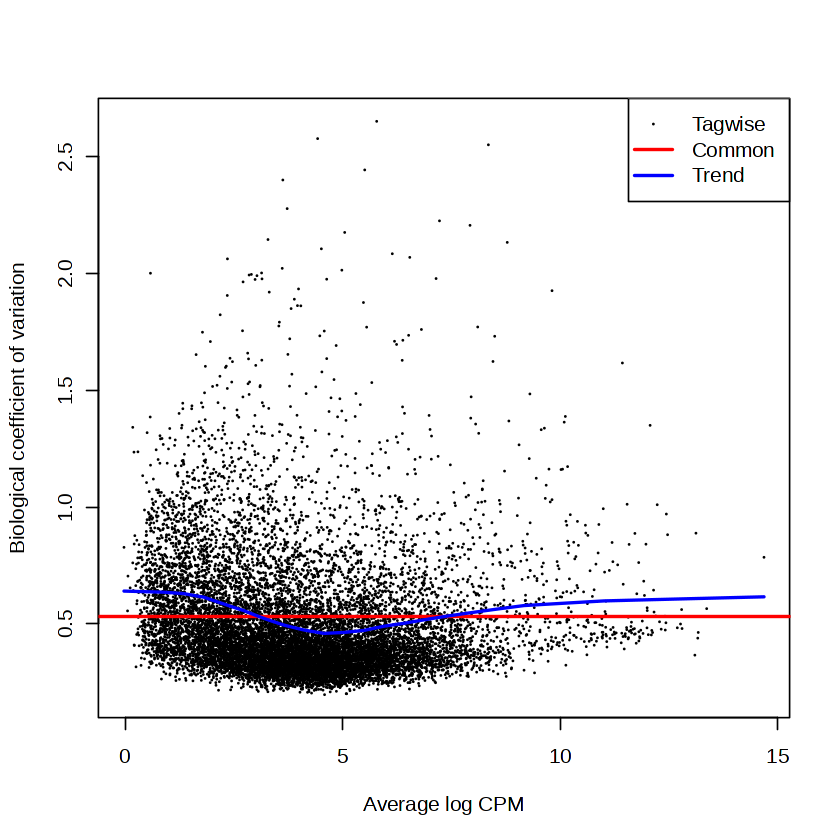

In [11]:
#########edgeR#########
DEGs <- DGEList(counts=mat_sub, group=groups)

#keep <- filterByExpr(DEGs, min.count=50, min.total.count=100)
keep <- filterByExpr(DEGs)
DEGs <- DEGs[keep, , keep.lib.sizes=FALSE]

DEGs <- calcNormFactors(DEGs)

#cdr <- scale(colMeans(mat_sub > 0))
#design <- model.matrix(~cdr+groups)
design <- model.matrix(~groups)

DEGs <- estimateDisp(DEGs, design = design)
fit <- glmQLFit(DEGs, design = design)
qlf <- glmQLFTest(fit,coef=2)
tt <- topTags(qlf, n = Inf)
plotBCV(DEGs)

et <- exactTest(DEGs)
et_FDR <- topTags(et, n = nrow(et$table), adjust.method = "BH", sort.by = "PValue", p.value = 1)

out_temp <- et_FDR$table

In [12]:
#out_temp
edge_mut_up <- out_temp[which(out_temp$FDR<0.01 & out_temp$logFC>0), ]

In [13]:
out_temp %>% head

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
USP12,-1.884455,4.695015,3.538386e-16,4.591056e-12
ARSG,-3.599661,5.943504,7.099423e-16,4.605751e-12
TSC22D1,-2.022376,7.464135,1.066167e-15,4.611174e-12
EIF4A2,-1.826060,8.076821,1.852899e-15,6.010340e-12
ID2,-2.183292,7.883640,1.261159e-14,2.998569e-11
ENPP4,-3.003036,3.876176,1.386622e-14,2.998569e-11


In [17]:
write.table(out_temp, file='./Pseudobulk_Fibro_DEG_all_filterByDefault.xls',quote=F,sep="\t")